# Coordinate Transformation Tests
In this notebook, we are going to test the coordinate transformation of loop coordinates

In [123]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.wcs
import sunpy.map
import sunpy.coordinates
import sunpy.sun.constants
import sunpy.time
from sunpy.visualization import wcsaxes_compat
import sunpy.data.sample
from solarbextrapolation.example_data_generator import dummyDataToMap

import synthesizAR

%matplotlib inline

The first thing we want to do is see if we can plot a heliographic coordinate overlay by itself.

In [311]:
fake_meta = {
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    'cunit1': 'arcsec',
    'cunit2': 'arcsec',
    'cdelt1': 200,
    'cdelt2': 200,
    'crval1': 0,
    'crval2': 0,
    'crpix1': 5.5,
    'crpix2': 5.5,
    'dsun_ref': sunpy.sun.constants.au.value,
    'dsun_obs': sunpy.sun.constants.au.value,
    'hgln_obs': 90,
    'hglt_obs': 0,
    'date_obs': '2017-01-01T00:00:00.00Z'
}

In [312]:
fake_map = sunpy.map.Map(np.nan*np.ones((10,10)),fake_meta)

We'll choose the center of our fake AR to be significantly offset from the center

In [313]:
fake_ar_center = SkyCoord(lon=0*u.deg,lat=90*u.deg,radius=sunpy.sun.constants.radius,
                          frame=sunpy.coordinates.frames.HeliographicStonyhurst)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


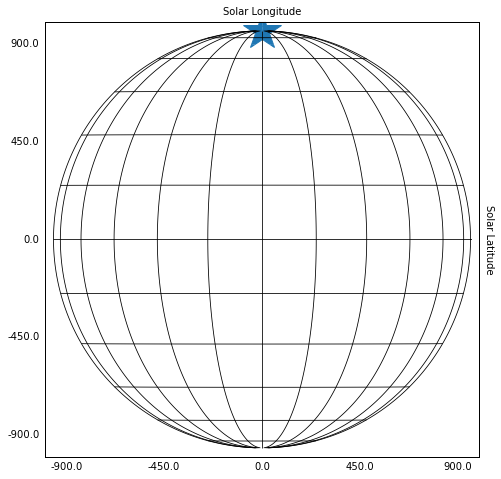

In [314]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection=fake_map)
fake_map.plot(title=False,annotate=False)
overlay = fake_map.draw_grid(color='k',alpha=1)
ax.plot_coord(fake_ar_center.transform_to(fake_map.coordinate_frame),'*',color='C0',markersize=40)

Now that we have a grid to plot on, lets create a bunch of fake loops in a locally flat cartesian system.

In [641]:
def make_synthetic_map(xrange,yrange,shape,spots):
    delta_x = xrange[1] - xrange[0]
    delta_y = yrange[1] - yrange[0]
    dx = delta_x/arr_grid_shape[0]
    dy = delta_y/arr_grid_shape[1]
    synthetic_hmi_data = np.zeros(arr_grid_shape)
    xphysical,yphysical = np.meshgrid(np.arange(arr_grid_shape[0])*dx,np.arange(arr_grid_shape[1])*dy)
    for spot in spots:
        if spot[0].unit is u.percent:
            pos = u.Quantity([spot[0][0].value/100.*delta_x + xrange[0],
                              spot[0][1].value/100.*delta_y + yrange[0]])
        else:
            pos = spot[0]
        if spot[1].unit is u.percent:
            sigma = spot[1].value/100.*delta_x
        else:
            sigma = spot[1]
        An_max   = spot[2].value
        An_x     = pos[0]
        An_y     = pos[1]
        An_Dx    = xphysical - An_x + xrange[0]
        An_Dy    = yphysical - An_y + yrange[0]
        An_DxSqu = An_Dx.value**2.0
        An_DySqu = An_Dy.value**2.0
        An_Sigma = sigma.value

        # So this contibution is calculated and added.
        synthetic_hmi_data += An_max * np.exp( - ( (An_DxSqu + An_DySqu) / (2 * An_Sigma**2.0)) )
        
    synthetic_hmi_map = dummyDataToMap(synthetic_hmi_data,xrange,yrange)
    test = sunpy.map.Map('/Users/willbarnes/sunpy/data/hmi_m_45s_2017_08_20_18_16_30_tai_magnetogram.fits')
    for key in ['ctype1','ctype2','rsun_ref','rsun_obs','dsun_ref','dsun_obs',
                'wcsname','crlt_obs','t_obs','date-obs']:
        synthetic_hmi_map.meta[key] = test.meta[key]
        
    return synthetic_hmi_map

In [642]:
arr_grid_shape = [ 300, 300]
xrange = u.Quantity([ 200.0, 500.0 ], u.arcsec)
yrange = u.Quantity([ 200.0, 500.0 ], u.arcsec)
spots = [
    ( u.Quantity([65,50],u.percent), 5*u.percent, -5e3*u.Gauss),
    ( u.Quantity([35,50],u.percent), 5*u.percent,  5e3*u.Gauss)
]
hmi_map = make_synthetic_map(xrange,yrange,arr_grid_shape,spots)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


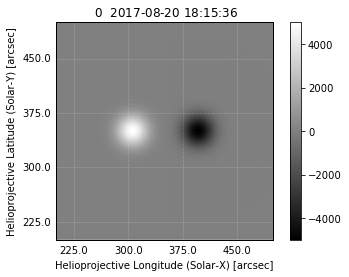

In [643]:
hmi_map.peek()

In [644]:
field = synthesizAR.Skeleton(hmi_fits_file=hmi_map,resample=u.Quantity([50,50],'pix'))
zrange = u.Quantity([0,300],'arcsec')
zshape = 50
field.extrapolate_field(zshape,zrange)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:81: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This property is only valid for non-ro

True


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:187: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:188: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:195: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi_map.xrange).value,
/Users/willbarnes/anaconda/envs/synthesizar/lib/p

In [645]:
field.extract_streamlines(200,
                          close_threshold=0.05,
                          mask_threshold=0.2,
                          safety=2,
                          loop_length_range=[1e9,5e11]*u.cm)
field.make_loops()

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/util/util.py:64: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_x = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.xrange)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/util/util.py:65: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_y = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.yrange)
yt : [INFO     ] 2018-02-03 16:08:18,654 AMRKDTree rebuilt, Final Volume: 8.008201e+30
Streamlining: 100%|██████████| 200/200 [00:00<00:00, 831.40it/s]
yt : [INFO     ] 2018-02-03 16:08:19,175 AMRKDTree rebuilt, Final Volume: 8.008201e+30
Streamlining: 100%|██████████| 64/64 [00:00<00:00, 821.86it/s]
yt : [INFO     ] 2018-02-03 16:08:19,414 AMRKDTree rebuilt, Final Volume: 8.008201e+30
Streamlining:

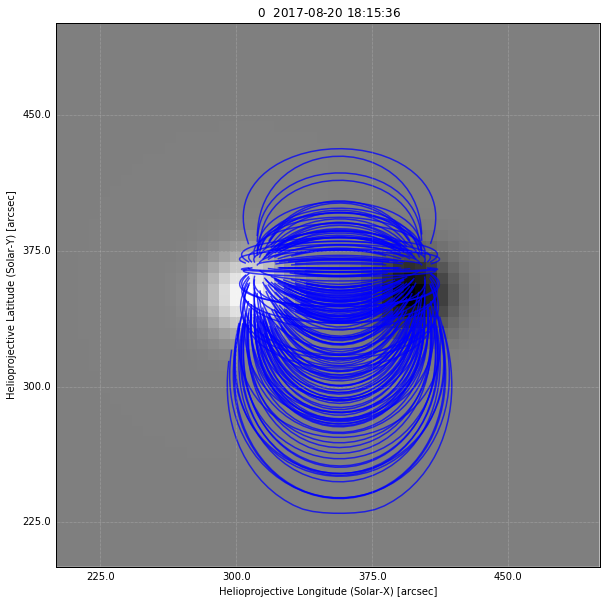

In [646]:
field.peek()

Next, make a change of coordinates such that the coordinates for the loops are expressed in the HCC coordinate frame of our fake map, with the center of the fake AR being significantly offset from the center.

In [647]:
def rotation_z(angle):
    angle = angle.to(u.radian)
    return np.array([[np.cos(angle), -np.sin(angle), 0],
                     [np.sin(angle), np.cos(angle), 0],
                     [0, 0, 1]])


def rotation_y(angle):
    angle = angle.to(u.radian)
    return np.array([[np.cos(angle), 0, np.sin(angle)],
                    [0, 1, 0],
                    [-np.sin(angle), 0, np.cos(angle)]])

def rotation_x(angle):
    angle = angle.to(u.radian)
    return np.array([[1, 0, 0],
                    [0, np.cos(angle), -np.sin(angle)],
                    [0, np.sin(angle), np.cos(angle)]])

def euler_z(angle):
    angle = angle.to(u.radian)
    return np.array([[np.cos(angle), np.sin(angle), 0],
                     [-np.sin(angle), np.cos(angle), 0],
                     [0, 0, 1]])

def euler_xprime(angle):
    angle = angle.to(u.radian)
    return np.array([[1, 0, 0],
                     [0, np.cos(angle), np.sin(angle)],
                     [0, -np.sin(angle), np.cos(angle)]])


def heeq_to_hcc(x_heeq, y_heeq, z_heeq, observer):
    Phi0 = observer.lon.to(u.radian)
    B0 = observer.lat.to(u.radian)
    x_hcc = y_heeq*np.cos(Phi0) - x_heeq*np.sin(Phi0)
    y_hcc = z_heeq*np.cos(B0) - x_heeq*np.sin(B0)*np.cos(Phi0) - y_heeq*np.sin(Phi0)*np.sin(B0)
    z_hcc = z_heeq*np.sin(B0) + x_heeq*np.cos(B0)*np.cos(Phi0) + y_heeq*np.cos(B0)*np.sin(Phi0)
    return x_hcc,y_hcc,z_hcc

In [585]:
fake_meta = {
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    'cunit1': 'arcsec',
    'cunit2': 'arcsec',
    'cdelt1': 200,
    'cdelt2': 200,
    'crval1': 0,
    'crval2': 0,
    'crpix1': 5.5,
    'crpix2': 5.5,
    'dsun_ref': sunpy.sun.constants.au.value,
    'dsun_obs': sunpy.sun.constants.au.value,
    'hgln_obs': 0,
    'hglt_obs': 0,
    'date_obs': '2017-01-01T00:00:00.00Z'
}
fake_map = sunpy.map.Map(np.nan*np.ones((10,10)),fake_meta)

In [590]:
test_pt_a = u.Quantity([[0,0,0],[0.5*sunpy.sun.constants.radius.to(u.cm).value,0,0]],u.cm)
test_pt_b = u.Quantity([[0,0,0],[0,0.5*sunpy.sun.constants.radius.to(u.cm).value,0]],u.cm)
test_pt_c = u.Quantity([[0,0,0],[0,0,0.5*sunpy.sun.constants.radius.to(u.cm).value]],u.cm)

In [591]:
fake_ar_center = SkyCoord(lon=0*u.deg,
                          lat=0*u.deg,
                          radius=sunpy.sun.constants.radius,
                          frame=sunpy.coordinates.frames.HeliographicStonyhurst)
hcc_center = fake_ar_center.transform_to(sunpy.coordinates.frames.Heliocentric(observer=fake_map.observer_coordinate))

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.47754000e+10   0.00000000e+00   0.00000000e+00]] cm
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.47754000e+10   0.00000000e+00]] cm
<SkyCoord (Helioprojective: obstime=2017-01-01 00:00:00, rsun=695508000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2017-01-01 00:00:00): (lon, lat, radius) in (deg, deg, m)
    ( 10.,  10.,   2.99195741e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    [( -83.44922015, -82.1814324 ,   2.98521254e+08),
     ( 153.21330474, -89.44463467,   2.98461846e+08)]>


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


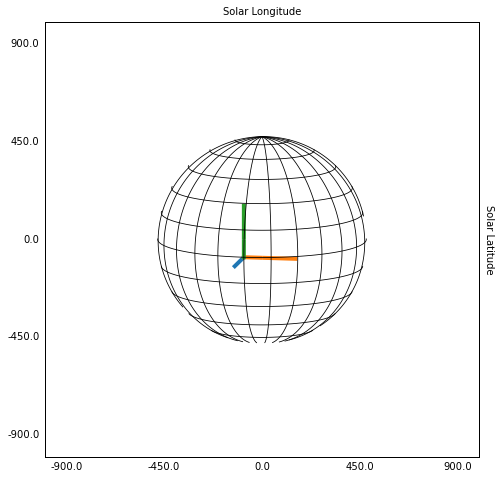

In [592]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection=fake_map)
fake_map.plot(title=False,annotate=False)
overlay = fake_map.draw_grid(color='k',alpha=1)
# First axis
x_axis = ( rotation_z(fake_ar_center.lon) @ rotation_y(-fake_ar_center.lat) @ test_pt_a.T).T
print(x_axis)
x_axis = u.Quantity(heeq_to_hcc(x_axis[:,0],
                                x_axis[:,1],
                                x_axis[:,2],
                                fake_map.observer_coordinate))
x_axis = x_axis.T + hcc_center.data.xyz
x_axis = SkyCoord(x_axis[:,0],x_axis[:,1],x_axis[:,2],frame=sunpy.coordinates.frames.Heliocentric,
                  observer=fake_map.observer_coordinate).transform_to(fake_map.coordinate_frame)
ax.plot_coord(x_axis,color='C0',lw=4)
# Second axis
y_axis = ( rotation_z(fake_ar_center.lon) @ rotation_y(-fake_ar_center.lat) @ test_pt_b.T).T
print(y_axis)
y_axis = u.Quantity(heeq_to_hcc(y_axis[:,0],
                                y_axis[:,1],
                                y_axis[:,2],
                                fake_map.observer_coordinate))
y_axis = y_axis.T + hcc_center.data.xyz
y_axis = SkyCoord(y_axis[:,0],y_axis[:,1],y_axis[:,2],frame=sunpy.coordinates.frames.Heliocentric,
                  observer=fake_map.observer_coordinate).transform_to(fake_map.coordinate_frame)
ax.plot_coord(y_axis,color='C1',lw=4)
# Third axis
z_axis = ( rotation_z(fake_ar_center.lon) @ rotation_y(-fake_ar_center.lat) @ test_pt_c.T).T
print(y_axis)
z_axis = u.Quantity(heeq_to_hcc(z_axis[:,0],
                                z_axis[:,1],
                                z_axis[:,2],
                                fake_map.observer_coordinate))
z_axis = z_axis.T + hcc_center.data.xyz
z_axis = SkyCoord(z_axis[:,0],z_axis[:,1],z_axis[:,2],frame=sunpy.coordinates.frames.Heliocentric,
                  observer=fake_map.observer_coordinate).transform_to(fake_map.coordinate_frame)
ax.plot_coord(z_axis,color='C2',lw=4)

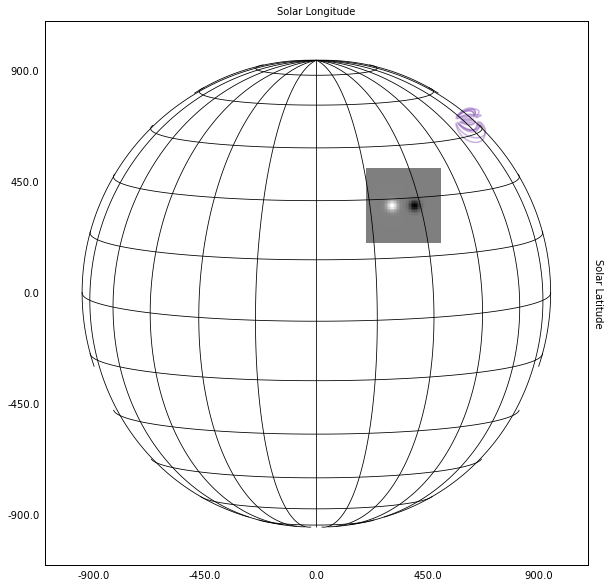

In [648]:
#fake_map = fake_map.submap(
#    SkyCoord(450*u.arcsec,100*u.arcsec,frame=fake_map.coordinate_frame),
#    SkyCoord(1000*u.arcsec,1000*u.arcsec,frame=fake_map.coordinate_frame)
#)
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=field.hmi_map)
field.hmi_map.plot(title=False,annotate=False)
ax.grid(alpha=0)
overlay = field.hmi_map.draw_grid(color='k',alpha=1)
ax.plot_coord(SkyCoord(Tx=[-1000,]*u.arcsec,Ty=[-1000,]*u.arcsec,frame=hmi_map.coordinate_frame),
              marker='o',color='w',)
ax.plot_coord(SkyCoord(Tx=[1000]*u.arcsec,Ty=[1000]*u.arcsec,frame=hmi_map.coordinate_frame),
              marker='o',color='w',)
hgs_center = field.hmi_map.center.transform_to('heliographic_stonyhurst')
hcc_center = field.hmi_map.center.transform_to(sunpy.coordinates.frames.Heliocentric(observer=field.hmi_map.observer_coordinate))
for loop in field.loops[::10]:
    coord = np.roll(loop.coordinates,1,axis=1)
    coord = ( rotation_z(hgs_center.lon) @ rotation_y(-hgs_center.lat) @ coord.T).T
    x_hcc,y_hcc,z_hcc = heeq_to_hcc(coord[:,0],
                                    coord[:,1],
                                    coord[:,2],
                                    field.hmi_map.observer_coordinate)
    x_hcc += hcc_center.x
    y_hcc += hcc_center.y
    z_hcc += hcc_center.z
    loop_coord = SkyCoord(x_hcc,
                          y_hcc,
                          z_hcc,
                          frame=sunpy.coordinates.frames.Heliocentric,
                          observer=field.hmi_map.observer_coordinate).transform_to(field.hmi_map.coordinate_frame)
    ax.plot_coord(loop_coord,ls='-',alpha=0.5,color='C4')